## Sentiment analysis

In real world, we all have constant evolution about natural language processing, one of classic task is sentiment analysis to predict text classification. This task is very important still nowdays...

# 1) Import dependencies

In [1]:
import pyspark

conf = pyspark.SparkConf()
conf.setAppName('Minha aplicação')
conf.setMaster('local[*]')
å
conf.set("spark.executor.memory", "2g")

conf.set("spark.driver.memory", "1g")

conf.set("spark.executor.memoryOverhead", "512")
conf.set("spark.driver.memoryOverhead", "512")

sc = pyspark.SparkContext(conf=conf)

In [2]:
sc

<SparkContext master=local[*] appName=Minha aplicação>

# 1.1) Load data

We will use review file to train our model.

In [3]:
def parse_line(line):
    parts = line[1:-1].split('","')
    sentiment = int(parts[0])
    title = parts[1].replace('""', '"')
    body = parts[2].replace('""', '"')
    return (sentiment, title, body)

rdd = sc.textFile('../train.csv').map(parse_line)

In [4]:
print('The len of data is: ', rdd.count())

The len of data is:  3600000


In [5]:
# Sanity Check:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Yay! We have a dataset with 3600000 instances labaled!

In [6]:
import os

pickle_filename = 'reviews.pickle'
if pickle_filename not in os.listdir():
    print('Saving as pickle file...')
    rdd.saveAsPickleFile(pickle_filename)
else:
    print('Getting pickle file...')
    rdd = sc.pickleFile('reviews.pickle')

Getting pickle file...


# 2) Let's create first Classifier!

In here, we will create Naive-bayes classifier. So, let's started!

Remember, all data science project follow this step-by-step:

- i)   Data aquisition and Sanity Check data
- ii)  Explore data
- iii) Pre-processing
- iv)  Create model
- v)   Train model
- vi)  Evaluate model
- vii) Deploy model

In our case, we just complete i), ii) (not required to exploring in this text mode), so let's pre-processing data!

## 2.2) Pre-processing

To treat all this data, let's build a class and discuss all step-by-step:

In [7]:
import numpy as np

'''

Slice dataset in train-test

'''

def train_test_split(rdd, test_size=0.2, random_seed=42):
    # Divida o RDD em duas partes: 70% e 30%
    rdd_partes = rdd.randomSplit([1-test_size, test_size], seed=random_seed)
    
    # Acesse as partes individualmente
    train = rdd_partes[0]
    test = rdd_partes[1]
    return train, test

In [8]:
rdd_train_full, _ = train_test_split(rdd, test_size=0.0001)
rdd_train, rdd_test = train_test_split(rdd_train_full, test_size=0.2)

In [9]:
rdd_test.count()

720304

In [ ]:
class BaseModel:
    def _init_(self):
        self.n_total_words = None
        self.rdd_label_1 = None
        self.rdd_label_2 = None
        self.rdd_full = None
        self.total_bag_1 = None
        self.total_bag_2 = None
        self.total_bag = None
        self.log_prob_C_1 = None
        self.log_prob_C_2 = None
        
    def tokenizer(self, X):
        return X.split()
    
    def get_log_probs(self, tokens, label=1):
    
        if label == 1:
            return [self.bag[token]['log_prob_negative'] for token in tokens if token in self.bag]
        return [self.bag[token]['log_prob_positive'] for token in tokens if token in self.bag]
    
    def get_words(self, rdd):
        value = rdd.map(lambda x: x[1].strip().lower() + ' ' + x[2].strip().lower()).flatMap(lambda x: x.split()).map(lambda x: (x, 1)) \
                .reduceByKey(lambda x, y: x + y)
        return value
        
    def get_tokens(self, rdd):
        return rdd.map(lambda x: x[1].strip().lower() + ' ' + x[2].strip().lower()).flatMap(lambda x: x.split())
    
    def get_count(self, rdd):
        value = self.get_tokens(rdd).map(lambda x: (x, 1)) \
                    .reduceByKey(lambda x, y: x + y)
        return value
    
    def total_words(self, rdd):
        return rdd.reduce(lambda x, y: ('', x[1] + y[1]))[1]
    
    def to_log(self, rdd):
        return rdd.map(lambda x: (x[0], np.log10(x[1]), np.log10(x[2]) ))

    def get_label(self, rdd, label=1):
        return rdd.filter(lambda x: True if x[0] == label else False)

    def full_outer_join(self, rdd_label_2, rdd_label_1):
        return rdd_label_2.fullOuterJoin(rdd_label_1).map(lambda x: (x[0], x[1][0], x[1][1]))

    def get_total_words(self, rdd_label):
        return rdd_label.map(lambda x: (x[1], 1)).reduce(lambda x, y: ('', x[1] + y[1]))[1]

    def laplace(self, rdd, alpha=1.0):

        '''

        TODO LAPLACE

        '''
        
        def check(x):
            if x:
                return x
            return 0.0
            
        total_1_2 = rdd.reduce(lambda x, y: ('', check(x[1]) + check(y[1]), check(x[2]) + check(y[2])))[1:]
        
        return rdd.map(lambda x: (x[0], (check(x[1]) + alpha) / (total_1_2[0] + 2 * alpha),  (check(x[2]) + alpha) / (total_1_2[1] + 2 * alpha) ))

In [11]:
class NaiveBayesClassifier(BaseModel):
    def __init__(self):
        super(NaiveBayesClassifier, self).__init__()
        self.sc = sc
        self.bag = None
        self.broadcast_bag = None
    
    def train(self, X, y=None):
        
        rdd = X
        
        self.n_total_words = self.total_words(self.get_count(rdd))
        print('Get total words...')
        self.rdd_label_1 = self.get_count(self.get_label(rdd, label=1))
        print('Get label 1 words...')
        self.rdd_label_2 = self.get_count(self.get_label(rdd, label=2))
        print('Get label 2 words...')
        self.rdd_full_temp = self.full_outer_join(self.rdd_label_2, self.rdd_label_1)
        print('Get all log probs...')

        self.rdd_full = self.to_log(self.laplace(self.rdd_full_temp))
        
        self.total_bag_1 = self.get_total_words(self.rdd_label_1)
        print('Get bag 1...')
        self.total_bag_2 = self.get_total_words(self.rdd_label_2)
        print('Get bag 2...')
    
        self.total_bag = self.get_total_words(self.rdd_full)
        print('Get total bag...')
        
        self.log_prob_C_1 = np.log10(self.total_bag_1 / self.total_bag)
        self.log_prob_C_2 = np.log10(self.total_bag_2 / self.total_bag)
        
        print('Creating hashtable...')
        self.bag = {k: {'log_prob_positive': lp, 'log_prob_negative': ln} for k, lp, ln in self.rdd_full.collect()}
        print('Done!')
        
        return None

    def predict(self, X):

        tokens = self.tokenizer(X)
        log_probs_1 = self.log_prob_C_1 + sum(self.get_log_probs(tokens, label=1))
        log_probs_2 = self.log_prob_C_2 + sum(self.get_log_probs(tokens, label=2))
        # print(log_probs_1, log_probs_2)

        y_hat = 1 if log_probs_1 > log_probs_2 else 2
        buffer = np.exp(np.array([log_probs_1, log_probs_2]))
        probs = buffer / buffer.sum()
        entropy = - probs[0] * np.log(probs[0]) - probs[1] * np.log(probs[1])
        return y_hat, probs, entropy

    def predict_rdd(self, rdd):
        local_broadcast_bag = sc.broadcast(self.bag)
        local_broadcast_log_prob_C_1 = sc.broadcast(self.log_prob_C_1)
        local_broadcast_log_prob_C_2 = sc.broadcast(self.log_prob_C_2)
        
        def predict_review_(review):
            tokens = review.lower().split()
            bag = local_broadcast_bag.value
            log_prob_C_1 = local_broadcast_log_prob_C_1.value
            log_prob_C_2 = local_broadcast_log_prob_C_2.value
            log_probs_1 = sum([bag[token]['log_prob_negative'] for token in tokens if token in bag]) + log_prob_C_1
            log_probs_2 = sum([bag[token]['log_prob_positive'] for token in tokens if token in bag]) + log_prob_C_2
            return log_probs_1, log_probs_2
        
        def predict_rdd_(rdd):
            return rdd.map(lambda x: (x[1] + ' ' + x[2], x[0], predict_review_(x[1] + ' ' + x[2]))).map(lambda x: (x[0], x[1], 1 if x[2][0] > x[2][1] else 2))
        return predict_rdd_(rdd)
    

In [12]:
model = NaiveBayesClassifier()

In [13]:
model.train(rdd_train)

Get total words...
Get label 1 words...
Get label 2 words...
Get all log probs...
Get bag 1...
Get bag 2...
Get total bag...
Creating hashtable...
Done!


In [14]:
sample = '''
    This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! 
    I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! 
    It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
'''.lower() # True label = 2 (positive)

In [15]:
model.predict(sample)

(2, array([4.20806941e-04, 9.99579193e-01]), 0.0036917922992067476)

## Word Cloud

In [16]:
def get_biggest_gradient(rdd, get_postive=True):
    mapped = rdd.map(lambda x: (x[0], np.exp(x[1]) - np.exp(x[2])))
    sorted_rdd = mapped.sortBy(lambda x: x[1], ascending=not get_postive)
    return sorted_rdd

In [17]:
more_positive = get_biggest_gradient(model.rdd_full).take(100)
more_negative = get_biggest_gradient(model.rdd_full, get_postive=False).take(100)

In [18]:
more_positive, more_negative

([('great', 0.04615549417207793),
  ('love', 0.030575993266388136),
  ('best', 0.03016886013413493),
  ('excellent', 0.029416336257016455),
  ('easy', 0.024030933562705407),
  ('wonderful', 0.02166573718514317),
  ('highly', 0.021583687363949212),
  ('perfect', 0.02050880215843327),
  ('favorite', 0.019429581333504236),
  ('awesome', 0.01819069932066581),
  ('loves', 0.017870036572930497),
  ('and', 0.01784922272839104),
  ('amazing', 0.017436946285462888),
  ('well', 0.016973744899285256),
  ('fun', 0.016307063761349466),
  ('enjoyed', 0.015224546902816303),
  ('beautiful', 0.014999246010308831),
  ('loved', 0.01488606628225959),
  ('good', 0.014292618941656357),
  ('great!', 0.014031717004544505),
  ('fantastic', 0.013439184767758159),
  ('album', 0.013432491139540183),
  ('works', 0.013258274122322847),
  ('must', 0.012862129281694147),
  ('classic', 0.012332898771743154),
  ('life', 0.012275225064095379),
  ('nice', 0.012198623362600518),
  ('it!', 0.011837310276504618),
  ('recomm

In [19]:
!pip install wordcloud

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

more_positives_d = dict(more_positive)
more_positives_n = dict(more_negative)

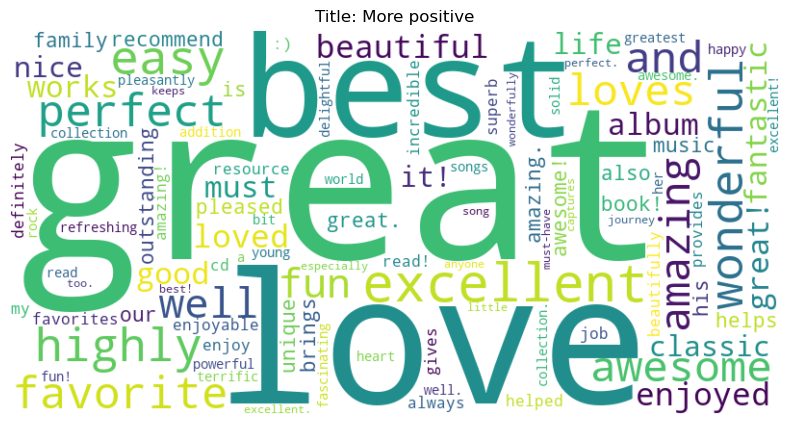

In [21]:
# Crie uma instância do WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(more_positives_d)

# Plote a Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Title: More positive')
plt.show()

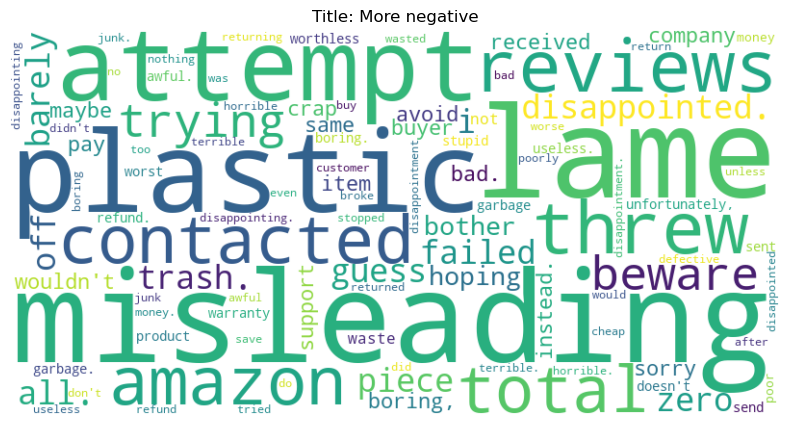

In [22]:
# Crie uma instância do WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(more_positives_n)

# Plote a Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Title: More negative')
plt.show()

## Evaluate model

In [23]:
def get_accuracy_rdd(rdd_predictions):
    counts = rdd_predictions.map(lambda x: (1, (x[1] == x[2], 1))) \
                            .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])) \
                            .map(lambda x: x[1]) \
                            .collect()
    count_correct, count_total = counts[0]
    return count_correct / count_total

def get_precision_rdd(rdd_predictions):
    count_true_positive = rdd_predictions.filter(lambda x: x[1] == 2 and x[2] == 2).count()
    count_false_positive = rdd_predictions.filter(lambda x: x[1] == 1 and x[2] == 2).count()
    return count_true_positive / (count_true_positive + count_false_positive)

def get_recall_rdd(rdd_predictions):
    count_true_positive = rdd_predictions.filter(lambda x: x[1] == 2 and x[2] == 2).count()
    count_false_negative = rdd_predictions.filter(lambda x: x[1] == 2 and x[2] == 1).count()
    return count_true_positive / (count_true_positive + count_false_negative)

def evaluate_rdd(rdd_predictions):
    accuracy = get_accuracy_rdd(rdd_predictions)
    precision = get_precision_rdd(rdd_predictions)
    recall = get_recall_rdd(rdd_predictions)
    f1 = 2 * precision * recall / (precision + recall)
    return accuracy, precision, recall, f1

In [24]:
def get_accuracy(predictions):
    count_correct = 0
    for x in predictions:
        if x[1] == x[2]:
            count_correct += 1
    count_total = len(predictions)
    return count_correct / count_total

def get_precision(predictions):
    
    count_true_positive = 0
    for x in predictions:
        if x[1] == 2 and x[2] == 2:
            count_true_positive += 1
            
    count_false_positive = 0
    for x in predictions:
        if x[1] == 1 and x[2] == 2:
            count_false_positive += 1
            
    return count_true_positive / (count_true_positive + count_false_positive)

def get_recall(predictions):

    count_true_positive = 0
    for x in predictions:
        if x[1] == 2 and x[2] == 2:
            count_true_positive += 1

    count_false_negative = 0
    for x in predictions:
        if x[1] == 2 and x[2] == 1:
            count_false_negative += 1
    
    return count_true_positive / (count_true_positive + count_false_negative)

def evaluate(predictions):
    accuracy = get_accuracy(predictions)
    precision = get_precision(predictions)
    recall = get_recall(predictions)
    f1 = 2 * precision * recall / (precision + recall)
    return accuracy, precision, recall, f1

In [25]:
rdd_predictions = model.predict_rdd(rdd_test)

In [26]:
accuracy = get_accuracy_rdd(rdd_predictions)
accuracy

0.8608865145827317

In [28]:
print(f'Accuracy: {accuracy * 100 :.2f} %')

Accuracy: 86.09 %


In [29]:
precision = get_precision_rdd(rdd_predictions)

In [30]:
print(f'Precision: {precision * 100 :.2f} %')

Precision: 87.35 %


In [31]:
recall = get_recall_rdd(rdd_predictions)

In [32]:
print(f'Recall: {recall * 100 :.2f} %')

Recall: 84.38 %


In [33]:
f1 = evaluate_rdd(rdd_predictions)

In [34]:
print(f'F1: {f1 * 100 :.2f} %')

TypeError: unsupported format string passed to tuple.__format__

In [ ]:
print(f'Accuracy: {accuracy * 100 :.2f} %')
print(f'Precision: {precision * 100 :.2f} %')
print(f'Recall: {recall * 100 :.2f} %')
print(f'F1: {f1 * 100 :.2f} %')